In [1]:
import keras

Using TensorFlow backend.


In [2]:
from Models.functions.plot import plot_history, full_multiclass_report

In [59]:
from keras.layers import Activation, Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.models import Model, Sequential
#from Models.functions.preprocessing import clean
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
import numpy as np
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
import itertools
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

import pandas as pd
result = pd.DataFrame()

In [114]:
def create_model(filters = [100], kernel_size = [50], strides = [100], 
                 dropout_rate = [0.5], pool_size = [5], max_len = 1000):

    model = Sequential()

    # conv 1
    model.add(Conv1D(filters = filters[0], 
                     kernel_size = kernel_size[0],
                     strides = strides[0], 
                     activation = 'relu', 
                     input_shape = (max_len, 1) ))

    # pooling layer 1
    model.add(MaxPooling1D(pool_size = pool_size[0], strides = 1))
    model.add(Activation('relu'))

    model.add(Flatten())
    #model.add(Dropout(0.5))
    model.add(Dense(units = 100, activation = 'relu'))
    model.add(Dense(units = 3, activation = 'softmax'))

    model.compile(optimizer = 'adadelta', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [61]:


def get_results(model, y_espected, y_predicted):

    config = model.get_config()

    row = {}

    conv_layers = np.sum([1 if i['class_name'] == "Conv1D" else 0 for i in config])
    pooling_layers = np.sum([1 if i['class_name'] == "MaxPooling1D" else 0 for i in config])

    row.update({ '_accuracy': accuracy_score(y_espected, y_predicted) })
    row.update({ '_f1-score': f1_score(y_espected, y_predicted,average='weighted')})
    row.update({ 'conv_layers': conv_layers })
    row.update({ 'pooling_layers': pooling_layers })

    _, _, fscore, support = precision_recall_fscore_support(y_espected, y_predicted)

    [row.update({'_fscore_class_'+str(i[0]): i[1]}) for i in enumerate(fscore)]
    [row.update({'_support_class_'+str(i[0]): i[1]}) for i in enumerate(support)]

    idx = 1
    for i in config:
        if i['class_name'] == "Conv1D":
            j = str(idx)
            row.update({
                'filters_'+j: i['config']['filters'],
                'strides_'+j: i['config']['strides'],
                'kernel_size_'+j: i['config']['kernel_size'],
                'activation_'+j: i['config']['activation']
            })
        pass
    return row

In [51]:
def labelEncoder(y):
    le = preprocessing.LabelEncoder()
    le.fit(y)
    return (le.transform(y), len(le.classes_), list(le.classes_))

from sklearn.feature_extraction.text import TfidfVectorizer


In [91]:
from Models.functions.datasets import loadTrainTest
X_train, X_test, y_train, y_test = loadTrainTest("gender", "brblogset", "/home/rafael/GDrive/Data/Dataframe/")

y_train, n, _ = labelEncoder(y_train)
y_test, n, classes_names = labelEncoder(y_test)

X = np.concatenate([X_train, X_test])

vect = TfidfVectorizer(max_features=1000)

vect.fit(X)

X.shape, X_train.shape, X_test.shape

((2602,), (2081,), (521,))

In [92]:
X_train_tfidf = vect.transform(X_train).toarray()
X_test_tfidf = vect.transform(X_test).toarray()

X_train_tfidf.shape, X_test_tfidf.shape

((2081, 1000), (521, 1000))

In [93]:
max_length = np.max([len(x.split(" ")) for x in X_train])
mean_length = np.mean([len(x.split(" ")) for x in X_train])
mediam_length = np.median([len(x.split(" ")) for x in X_train])

print(max_length, mean_length, mediam_length, int(mediam_length), int(mediam_length) == 2255)

599293 5537.368572801538 2423.0 2423 False


### Normalizer

In [94]:
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import collections, numpy

# Synthetic Minority Oversampling Technique (SMOTE)
def oversampling(X, y):
    X_resampled, y_resampled = SMOTE().fit_resample(X, y)
    return X_resampled, y_resampled

X_resampled, y_resampled = oversampling(X_train_tfidf, y_train)

#scaler = StandardScaler().fit(X)
#m = scaler.transform(X)
#m = matrix2

collections.Counter(y_train), collections.Counter(y_resampled)

(Counter({0: 840, 1: 1241}), Counter({0: 1241, 1: 1241}))

### Split train and test

In [95]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


from keras.utils import to_categorical
#y_train = to_categorical(y_train, 2)
#y_test = to_categorical(y_test, 2)
print(len(y_train), len(x_train))
print(len(y_test), len(x_test))
#print()
#print(y_test)

x_test.shape, x_train[1].shape

(1985, 1000) (497, 1000) (1985,) (497,)
1985 1985
497 497


((497, 1000, 1), (1000, 1))

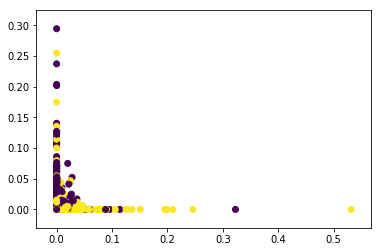

In [96]:

xid, yid = 10, 222
plt.scatter(x_train[:,xid], x_train[:,yid],c=y_train)
#plt.ylabel(classes_names[0])
#plt.ylabel(classes_names[1])

In [98]:
from time import time

CNN = KerasClassifier(build_fn=create_model, 
                epochs=1,
                #max_len=x_train[1],
                #batch_size=BATCH_SIZE,
                verbose=0,
                validation_split=0.1
                )

params_grid = dict(
        filters = [[50],[100]],
        kernel_size = [[30],[50]],
        strides = [[5],[10],[50]],
        dropout_rate = [[0.5]],
        pool_size = [[10],[15]],
        epochs = [50, 100]        
        #batch_size = 100
)                               

grid_search = GridSearchCV(CNN, 
                           params_grid, 
                           scoring='accuracy', cv=3, 
                           return_train_score=True
                           )

#print('best params', grid_search.best_params_)


print("Performing grid search...")    
t0 = time()

#histories = []
grid_results = grid_search.fit(x_train,y_train)

print("done in %0.2fs and %0.1fmin" % ((time() - t0), ((time() - t0) / 60) ))
print()

print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
display(pd.DataFrame(grid_search.cv_results_))

Performing grid search...
done in 5931.95s and 98.9min

Best parameters set:
	dropout_rate: [0.5]
	epochs: 100
	filters: [50]
	kernel_size: [50]
	pool_size: [15]
	strides: [5]


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_dropout_rate,param_epochs,param_filters,param_kernel_size,param_pool_size,param_strides,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,29.373501,0.368067,0.702771,0.870278,[0.5],50,[50],[30],[10],[5],...,0.694864,0.840514,0.731118,0.905518,0.682300,0.864804,0.144459,0.003838,0.020697,0.026819
1,15.403984,0.373201,0.703275,0.890428,[0.5],50,[50],[30],[10],[10],...,0.709970,0.907785,0.711480,0.872260,0.688351,0.891239,0.063238,0.008334,0.010563,0.014514
2,5.649614,0.366145,0.700756,0.807297,[0.5],50,[50],[30],[10],[50],...,0.703927,0.783069,0.719033,0.801209,0.679274,0.837613,0.067283,0.005426,0.016384,0.022680
3,29.506116,0.447054,0.697733,0.876572,[0.5],50,[50],[30],[15],[5],...,0.690332,0.845805,0.723565,0.897203,0.679274,0.886707,0.158460,0.007827,0.018822,0.022173
4,15.776733,0.464497,0.670025,0.830000,[0.5],50,[50],[30],[15],[10],...,0.688822,0.885865,0.697885,0.876039,0.623298,0.728097,0.040626,0.016844,0.033223,0.072168
5,5.514287,0.457508,0.658942,0.711589,[0.5],50,[50],[30],[15],[50],...,0.688822,0.755858,0.628399,0.674981,0.659607,0.703927,0.131727,0.015865,0.024678,0.033459
6,30.158983,0.543776,0.729975,0.924435,[0.5],50,[50],[50],[10],[5],...,0.740181,0.920635,0.738671,0.934996,0.711044,0.917674,0.184444,0.006631,0.013390,0.007565
7,16.952710,0.548508,0.691184,0.886902,[0.5],50,[50],[50],[10],[10],...,0.672205,0.896447,0.696375,0.877551,0.704992,0.886707,0.055997,0.009581,0.013878,0.007716
8,6.808253,0.537318,0.721914,0.880352,[0.5],50,[50],[50],[10],[50],...,0.728097,0.897203,0.729607,0.860922,0.708018,0.882931,0.068562,0.004988,0.009838,0.014924
9,30.286860,0.632781,0.720907,0.887900,[0.5],50,[50],[50],[15],[5],...,0.717523,0.872260,0.702417,0.868481,0.742814,0.922961,0.146532,0.008873,0.016663,0.024839


In [ ]:
params = best_parameters

## create the model with the best params found
model = create_model(filters=params['filters'],
                     kernel_size=params['kernel_size'],
                     strides=params['strides'],
                     dropout_rate=params['dropout_rate'],
                     pool_size=params['pool_size']
                    )

## Then train it and display the results
history = model.fit(x_train,
                    y_train,
                    epochs=250,#params['epochs'],
                    #batch_size=params['batch_size'],
                    verbose = 0)

model.summary()

directory='/home/rafael/'

plot_history(history, directory=directory)

full_multiclass_report(model,
                       x_test,
                       y_test,
                       classes=classes_names,
                       directory=directory
                      )
                       #batch_size=32,
                       #binary= )
        
        
#result = result
# get_results(model, y_test, model.predict_classes(X_test))

In [90]:
y_pred = model.predict_classes(x_test)
accuracy_score(y_test, y_pred)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[19, 10,  1],
       [21, 17,  1],
       [ 5,  7, 10]])